In [4]:
import xgboost
import pandas as pd

In [12]:
df = pd.read_csv("audio_video_features_test.csv", low_memory = False).drop(columns = ["Unnamed: 0.1", "Unnamed: 0", "index"])

In [34]:
ohe_df = df.replace("x", 1).fillna(0).replace("xx", 1)

features = list(ohe_df.columns)[13:]

In [75]:
y = ohe_df[["SD", "QE", "SV", "PR", "HD"]].values.reshape(-1, 5)
X = ohe_df[features].values
y_lab = np.argmax(y, axis = 1)
# import numpy as np
# for cl_ in ["SD", "QE", "SV", "PR", "HD"]:
#     print(len(ohe_df[ohe_df[cl_] == 1]))
y_lab[np.where(~y.any(axis=1))[0]] = 5

map_dict = dict(zip(["SD", "QE", "SV", "PR", "HD", "None"], [0, 1, 2, 3, 4, 5]))

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_lab, random_state=42, test_size = .15, stratify=y_lab)

In [91]:
_, count = np.unique(y_train, return_counts=True)
weights = [count[i] / count[-1] for i in range(6)]

In [92]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', 
                            num_class=6, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42,
                            sample_weight = weights)
xgb_clf.fit(X_train, 
            y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

[21:56:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "sample_weight" } are not used.

[0]	validation_0-merror:0.09451	validation_0-mlogloss:1.15031	validation_1-merror:0.10125	validation_1-mlogloss:1.17014
[1]	validation_0-merror:0.09265	validation_0-mlogloss:0.86962	validation_1-merror:0.09928	validation_1-mlogloss:0.90707
[2]	validation_0-merror:0.09195	validation_0-mlogloss:0.69460	validation_1-merror:0.09862	validation_1-mlogloss:0.75121
[3]	validation_0-merror:0.09149	validation_0-mlogloss:0.57392	validation_1-merror:0.09862	validation_1-mlogloss:0.64992
[4]	validation_0-merror:0.08905	validation_0-mlogloss:0.48508	validation_1-merror:0.09862	validation_1-mlogloss:0.58056
[5]	validation_0-merror:0.08859	validation_0-mlogloss:0.41987	validation_1-merror:0.09862	validation_1-mlogloss:0.53365
[6]	validation_0-merror:0.08545	validation_0-mlogloss:0.36769	validation_1-merror:0.09862	validation_1-mlogloss:0.50094
[7]	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['merror', 'mlogloss'], feature_types=None, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=1, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_class=6, num_parallel_tree=1, objective='multi:softprob', ...)

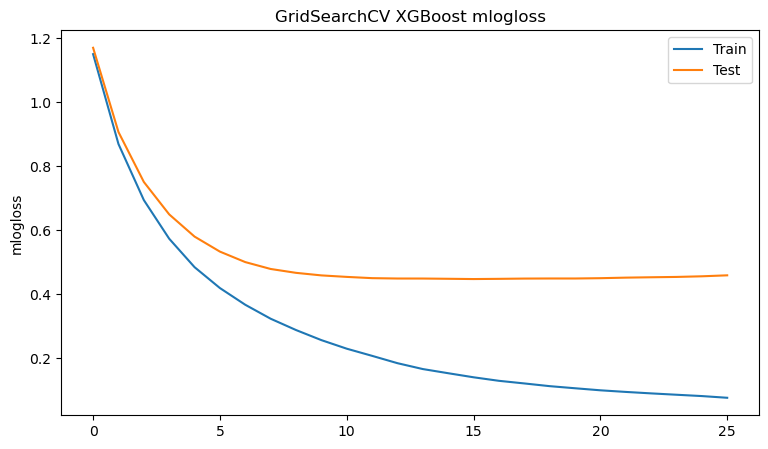

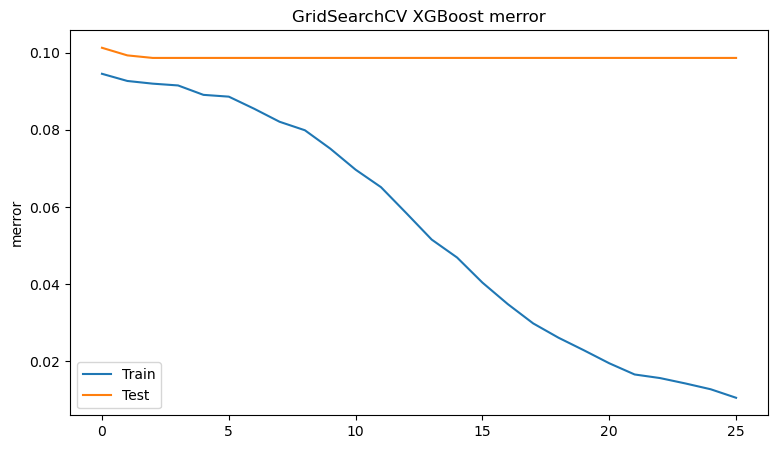

In [93]:
import matplotlib.pyplot as plt
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [94]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[   0    0    0    0    0   63]
 [   0    0    0    0    0   13]
 [   0    0    0    0    0    6]
 [   0    0    0    0    0    9]
 [   0    0    0    0    0   59]
 [   0    0    0    0    0 1371]]

-------------------- Key Metrics --------------------

Accuracy: 0.90
Balanced Accuracy: 0.17

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.15
Macro Recall: 0.17
Macro F1-score: 0.16

Weighted Precision: 0.81
Weighted Recall: 0.90
Weighted F1-score: 0.85

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        59
           5       0.90      1.00      0.95      1371

    accuracy    

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res